In [1]:
%load_ext autoreload
%autoreload 2

# Selenobot usage guide

The new Selenobot usage popeline has two main components: `Datasets` and `Classifiers`. These two components are each represented by a base class, from which more specialized versions inherit their core functionality. 

## Datasets

The classes in this category all inherit from the `Dataset` class, which in turn inherits from `torch.utils.data.Dataset` (this means they can be fed into a `torch.utils.data.DataLoader` for easy batching and training). 

1. `Dataset` is the base class. It provides the `__getitem__` method, as well as some other basic functions.
2. `EmbeddingDataset` supports `Datasets` which are made up of embedded sequence data. All objects which inherit from this class also have an `embed` method, which embeds the input sequence data. 
3. `EsmEmbeddingDataset` inherits from `EmbeddingDataset`. It supports the embedding of amino acid sequences using a pre-trained ESM model. 
4. `AacEmbeddingDataset` also inherits from `EmbeddingDataset`. It supports the embedding of amino acid sequences in Amino Acid Content (AAC) embedding space. 

## Classifiers

1. `Classifier` is the base class. It inherits from `torch.nn.Module`, and provides `train` and `test` methods. These methods both make use of a `forward` method, which is overwritten in child classes. 
2. `NextTokenClassifier` is still very much underdevelopment. This will use the ProtGPT2 model to classify non-embedded sequences using next-token prediction (although the exact technique for this is TBD). 
3. `EmbeddingClassifier` currently consists of a single linear layer with sigmoid activation (it definitely can be improved upon, with dropout layers, etc.) It trains this classifier on pre-generated embeddings to predict whether or not a sequence is a selenoprotein. 

In [2]:
from src.classifiers import *
from src.datasets import *

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/prichter/Documents/selenobot/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-04 16:45:20.214308: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-04 16:45:20.241167: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 16:45:20.606313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fi

## Examples

### Comparing `EmbeddingClassifiers` using Prot5 and ESM embeddings

Because the most immediate question is whether or not the Prot5 embeddings provide results which are as good as the ESM embeddings, I will try this first! I should note that, because I have the ESM embeddings already generated, I don't need to use the `EsmEmbeddingDataset`. This is really just useful for generating the embeddings, or if you wanted to clarify the type of embeddings contained in the dataset. 

In [3]:
data_dir = '/home/prichter/Documents/selenobot/data/'

In [4]:
pr5_train_dataset = EmbeddingDataset.from_csv(data_dir + 'train_embeddings_pr5.csv')
pr5_test_dataset = EmbeddingDataset.from_csv(data_dir + 'test_embeddings_pr5.csv')

We can extract the latent dimension of the embedding space using the following code. This will then be used as input to the `EmbeddingClassifier`.

In [5]:
latent_dim = pr5_test_dataset.latent_dim
print('Latent dimension of the Prot5 embedding space is', latent_dim)

Latent dimension of the Prot5 embedding space is 1024


In [6]:
classifier = EmbeddingClassifier(latent_dim)

In [7]:
pr5_train_dataloader = torch.utils.data.DataLoader(pr5_train_dataset, batch_size=64, shuffle=False)
pr5_test_dataloader = torch.utils.data.DataLoader(pr5_test_dataset, batch_size=64, shuffle=False)

In [8]:
losses = classifier.train_(pr5_train_dataloader, test_dataloader=pr5_test_dataloader, epochs=50)

100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


<Axes: >

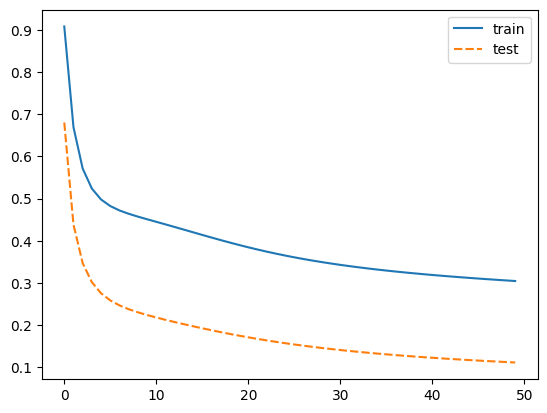

In [9]:
sns.lineplot(losses)

Now that we have a trained model, we can determine what the classification accuracy is. Eventually, I will make a method (or some other thing) to make calculating classification accuracy much easier. 

In [11]:
logits, _ = classifier(torch.Tensor(pr5_test_dataset.data))

logits = np.ravel(np.round(logits.detach().numpy())) # Convert to a numpy array for accuracy analysis. 
labels = pr5_test_dataset.metadata['label']

# print(logits)
# print(labels)

print('Classification accuracy is', (logits == labels).astype(float).mean())

Classification accuracy is 0.9507019951440937
